In [1]:
pip install catboost


In [2]:
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns






In [3]:
dados = pd.read_csv('/content/base_de_dados.csv')
dados.head(10)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.01.2005,25.722,26.193,26.492,25.671,"115,64M","-1,81%"
1,04.01.2005,24.848,25.722,25.873,24.791,"146,14M","-3,40%"
2,05.01.2005,24.692,24.859,25.001,24.523,"127,42M","-0,63%"
3,06.01.2005,24.367,24.695,24.808,24.250,"151,17M","-1,32%"
4,07.01.2005,24.747,24.376,24.874,24.376,"104,96M","1,56%"
5,10.01.2005,24.292,24.747,24.825,24.086,"126,23M","-1,84%"
6,11.01.2005,24.370,24.295,24.457,24.127,"111,40M","0,32%"
7,12.01.2005,24.510,24.370,24.560,23.983,"107,12M","0,57%"
8,13.01.2005,24.806,24.523,24.919,24.523,"91,08M","1,21%"
9,14.01.2005,24.924,24.802,24.966,24.481,"117,14M","0,48%"


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [5]:

dados.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


**ANALISE EXPLORATÓRIA**

In [6]:
#TRANSFORMAÇÃO DOS DADOS

dados['Data'] = pd.to_datetime(dados['Data'], format='%d.%m.%Y')
dados= dados.set_index('Data')
dados['Var%'] = dados['Var%'].str.replace(',','.').str.replace('%','').astype(float)
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2005-01-03 to 2025-03-11
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    5000 non-null   float64
 1   Abertura  5000 non-null   float64
 2   Máxima    5000 non-null   float64
 3   Mínima    5000 non-null   float64
 4   Vol.      4999 non-null   object 
 5   Var%      5000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 273.4+ KB


In [7]:
dados.head(10)

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,"115,64M",-1.81
2005-01-04,24.848,25.722,25.873,24.791,"146,14M",-3.40
2005-01-05,24.692,24.859,25.001,24.523,"127,42M",-0.63
2005-01-06,24.367,24.695,24.808,24.250,"151,17M",-1.32
2005-01-07,24.747,24.376,24.874,24.376,"104,96M",1.56
2005-01-10,24.292,24.747,24.825,24.086,"126,23M",-1.84
2005-01-11,24.370,24.295,24.457,24.127,"111,40M",0.32
2005-01-12,24.510,24.370,24.560,23.983,"107,12M",0.57
2005-01-13,24.806,24.523,24.919,24.523,"91,08M",1.21


In [8]:
#TRATANDO OS DADOS DA COLUNA VOLUME

def tratar_coluna_volume(coluna_volume):
    """
    Função para converter a coluna de volume de string para float.
    Lida com os sufixos 'k', 'M' e 'B'.
    """
    # Cria uma cópia para evitar warnings
    coluna_tratada = coluna_volume.astype(str).copy()

    # Define as substituições e os multiplicadores
    multiplicadores = {
        'k': 1_000,
        'M': 1_000_000,
        'B': 1_000_000_000
    }

    # Itera sobre o dicionário e substitui os valores
    for sufixo, multiplicador in multiplicadores.items():
        # Encontra os valores que terminam com o sufixo (case-insensitive)
        mask = coluna_tratada.str.contains(sufixo, case=False, na=False)

        # Converte a string para float, remove o sufixo e multiplica
        coluna_tratada.loc[mask] = (
            coluna_tratada.loc[mask]
            .str.replace(sufixo, '', case=False)
            .str.replace(',', '.')  # Trata a vírgula como separador decimal, se houver
            .astype(float)
            * multiplicador
        )

    # Converte os valores restantes que não tinham sufixo
    # Tenta converter para float, substituindo erros por NaN
    coluna_tratada = pd.to_numeric(coluna_tratada, errors='coerce')

    return coluna_tratada

# --- Exemplo de como usar a função no seu código ---

# Aplique a função para tratar a coluna de volume
dados['Vol.'] = tratar_coluna_volume(dados['Vol.'])

# Agora, o seu DataFrame 'dados' terá a coluna 'volume' no formato float,
# e você poderá usar ela em seus cálculos e engenharia de features.

# Exemplo: verificando o tipo da coluna
print(dados['Vol.'].dtype)


float64


In [9]:
dados.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81
2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40
2005-01-05,24.692,24.859,25.001,24.523,127420000.0,-0.63
2005-01-06,24.367,24.695,24.808,24.250,151170000.0,-1.32
2005-01-07,24.747,24.376,24.874,24.376,104960000.0,1.56


In [10]:
#RENOMEAR AS COLUNAS
dados = dados.rename(columns=({'Último': 'close', 'Abertura': 'open', 'Máxima': 'high', 'Mínima': 'low', 'Vol.': 'volume', 'Var%': 'var_pct'}))
dados.head(2)

,close,open,high,low,volume,var_pct
Data,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81
2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40


In [11]:
# Criar a variável-alvo (target)

dados['target'] = (dados['var_pct'].shift(-1) > 0).astype(int)

dados.head(2)


,close,open,high,low,volume,var_pct,target
Data,,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81,0
2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40,0


In [12]:
dados['volume'] = np.log1p(dados['volume'])  # log(1+x) para evitar log(0)

scaler = StandardScaler()
dados[['volume', 'var_pct']] = scaler.fit_transform(dados[['volume', 'var_pct']])

In [13]:
dados.isna().sum()

,0
close,0
open,0
high,0
low,0
volume,1
var_pct,0
target,0


In [14]:
dados.dropna(inplace=True)

In [15]:
dados['target'].value_counts(normalize=True)

,proportion
target,
1,0.517904
0,0.482096


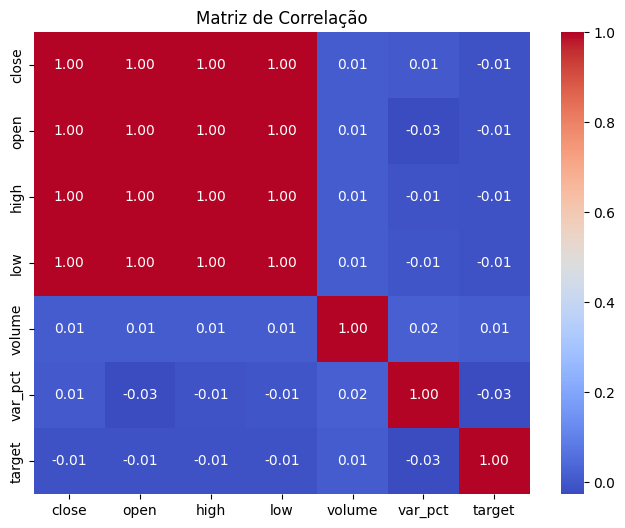

In [16]:



#HEATMAP PARA ANALISE DE CORRELAÇÃO

matriz_correlacao = dados.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


A matriz de correlação mostra que:

As variáveis de preço estão fortemente correlacionadas entre si, o que é esperado por se tratar de uma base financeira.

O volume_zscore e a var_pct não estão correlacionados com as variáveis de preço, tornando-os features independentes para o treinamento.

O ultimo é um forte candidato a preditor do proximo_fechamento.

In [17]:
dados = dados.copy()
dados.tail()

,close,open,high,low,volume,var_pct,target
Data,,,,,,,
2025-03-05,123.047,122.799,123.364,122.747,4.947947,0.093236,1
2025-03-06,123.358,123.048,124.112,122.681,4.979986,0.123294,1
2025-03-07,125.035,123.357,125.822,122.530,4.974521,0.790594,0
2025-03-10,124.519,125.031,125.031,123.471,4.931347,-0.273479,0
2025-03-11,123.507,124.519,124.625,122.636,4.889162,-0.513947,0


**TREINANDO O MODELO**

--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---
Gerando Curvas ROC para cada período de validação.

✅ Validação para o período: 2011-01-27 a 2011-03-11
Período de Treino: 2005-01-03 a 2011-01-26
              precision    recall  f1-score   support

           0       0.12      0.08      0.10        13
           1       0.45      0.59      0.51        17

    accuracy                           0.37        30
   macro avg       0.29      0.33      0.30        30
weighted avg       0.31      0.37      0.33        30

--------------------------------------------------
✅ Validação para o período: 2012-01-27 a 2012-03-12
Período de Treino: 2006-01-03 a 2012-01-26
              precision    recall  f1-score   support

           0       0.37      0.54      0.44        13
           1       0.45      0.29      0.36        17

    accuracy                           0.40        30
   macro avg       0.41      0.42      0.40        30
weighted avg       0.42      0.40      

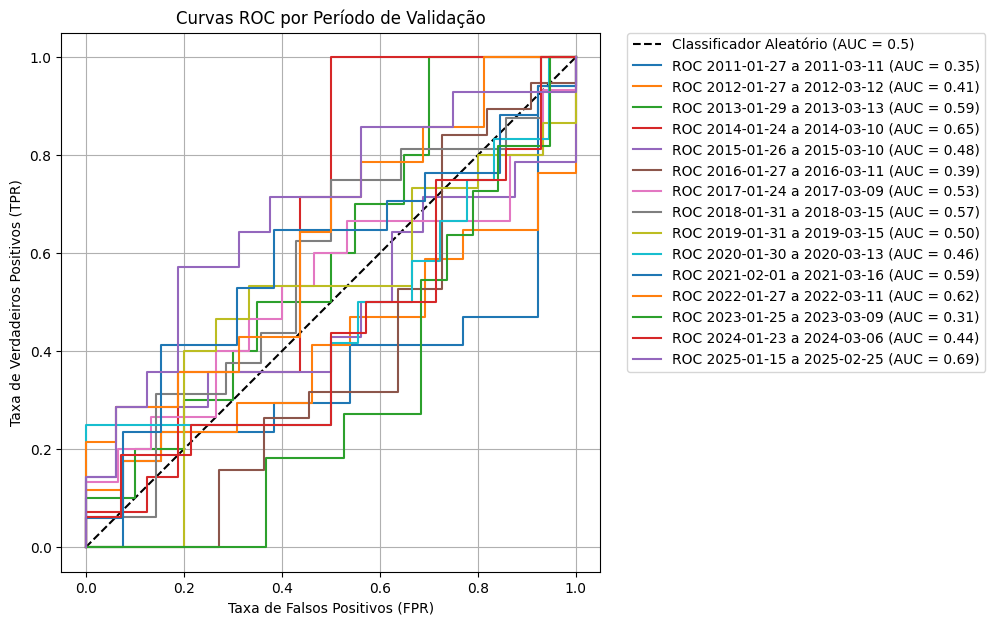

In [18]:

from datetime import timedelta
from sklearn.metrics import roc_curve, roc_auc_score

# Features e alvo
X = dados.drop(columns=['close','target', 'high', 'low'])
y = dados['target']

# Identificação de colunas categóricas (se houver)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline com SMOTE + CatBoost
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('modelo', CatBoostClassifier(
        iterations=500,              # número de árvores
        depth=6,                     # profundidade das árvores
        learning_rate=0.05,          # taxa de aprendizado
        eval_metric='BalancedAccuracy',
        random_seed=42,
        logging_level='Silent',      # silencia logs do CatBoost
        cat_features=cat_features    # se tiver categorias
    ))
])

# -------------------------
# Walk-Forward Validation
# -------------------------
print("--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---")
print("Gerando Curvas ROC para cada período de validação.\n")

anos_por_janela = 5
dias_validacao = 30
dias_salto = 365
dias_por_janela = anos_por_janela * 300
idx_inicio_treino = 0

# Inicializa o plot
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Período de Validação')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

while idx_inicio_treino + dias_por_janela + dias_validacao <= len(dados):
    idx_fim_treino = idx_inicio_treino + dias_por_janela
    idx_inicio_val = idx_fim_treino
    idx_fim_val = idx_inicio_val + dias_validacao

    X_treino_walk = X.iloc[idx_inicio_treino:idx_fim_treino]
    y_treino_walk = y.iloc[idx_inicio_treino:idx_fim_treino]
    X_val_walk = X.iloc[idx_inicio_val:idx_fim_val]
    y_val_walk = y.iloc[idx_inicio_val:idx_fim_val]

    if X_treino_walk.empty or X_val_walk.empty:
        break

    # Treina o modelo
    pipeline.fit(X_treino_walk, y_treino_walk)

    # Faz a predição das probabilidades
    y_val_proba_walk = pipeline.predict_proba(X_val_walk)[:, 1]

    # Calcula Curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_val_walk, y_val_proba_walk)
    roc_auc = roc_auc_score(y_val_walk, y_val_proba_walk)

    # Plota curva ROC
    periodo_label = f'{X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}'
    plt.plot(fpr, tpr, label=f'ROC {periodo_label} (AUC = {roc_auc:.2f})')

    print(f"✅ Validação para o período: {X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}")
    print(f"Período de Treino: {X_treino_walk.index[0].date()} a {X_treino_walk.index[-1].date()}")
    print(classification_report(y_val_walk, pipeline.predict(X_val_walk)))
    print("-" * 50)

    # Move janela
    proximo_salto_data = dados.index[idx_inicio_treino] + timedelta(days=dias_salto)
    idx_inicio_treino = np.argmax(dados.index >= proximo_salto_data)

# Finaliza o plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay


**TREINANDO COM PARAMETROS**

--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---
Gerando Curvas ROC para cada período de validação.

✅ Validação para o período: 2011-01-27 a 2011-03-11
Período de Treino: 2005-01-03 a 2011-01-26
              precision    recall  f1-score   support

           0       0.12      0.08      0.10        13
           1       0.45      0.59      0.51        17

    accuracy                           0.37        30
   macro avg       0.29      0.33      0.30        30
weighted avg       0.31      0.37      0.33        30

--------------------------------------------------
✅ Validação para o período: 2012-01-27 a 2012-03-12
Período de Treino: 2006-01-03 a 2012-01-26
              precision    recall  f1-score   support

           0       0.37      0.54      0.44        13
           1       0.45      0.29      0.36        17

    accuracy                           0.40        30
   macro avg       0.41      0.42      0.40        30
weighted avg       0.42      0.40      

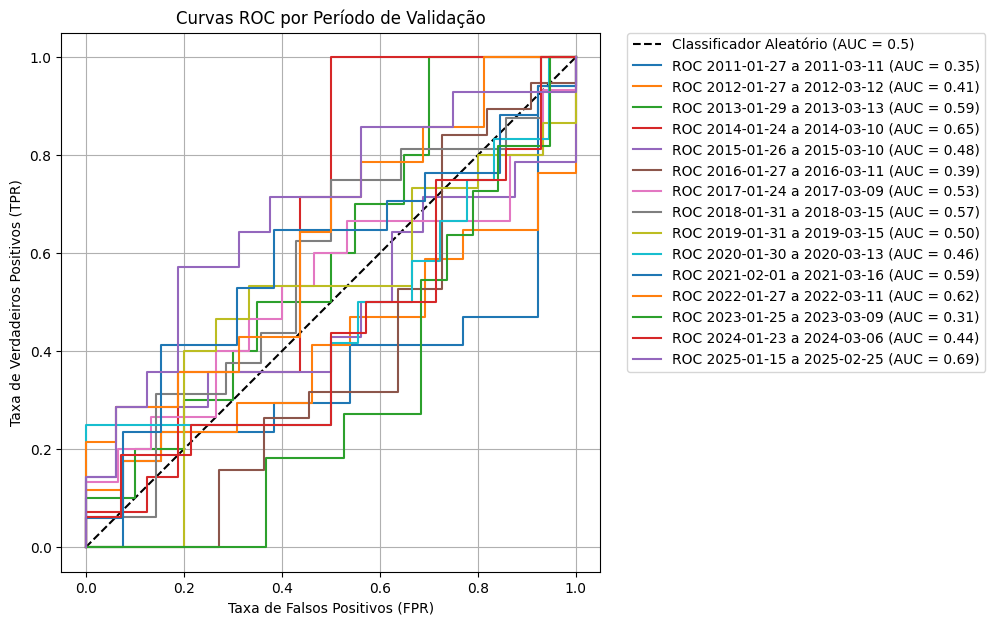

In [20]:
# Features e alvo
X = dados.drop(columns=['close','target', 'high', 'low'])
y = dados['target']

# Identificação de colunas categóricas (se houver)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline com SMOTE + CatBoost
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('modelo', CatBoostClassifier(
        iterations=500,              # número de árvores
        depth=6,                     # profundidade das árvores
        learning_rate=0.05,          # taxa de aprendizado
        eval_metric='BalancedAccuracy',
        random_seed=42,
        logging_level='Silent',      # silencia logs do CatBoost
        cat_features=cat_features    # se tiver categorias
    ))
])

# -------------------------
# Walk-Forward Validation
# -------------------------
print("--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---")
print("Gerando Curvas ROC para cada período de validação.\n")

anos_por_janela = 5
dias_validacao = 30
dias_salto = 365
dias_por_janela = anos_por_janela * 300
idx_inicio_treino = 0

# Inicializa o plot
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Período de Validação')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

while idx_inicio_treino + dias_por_janela + dias_validacao <= len(dados):
    idx_fim_treino = idx_inicio_treino + dias_por_janela
    idx_inicio_val = idx_fim_treino
    idx_fim_val = idx_inicio_val + dias_validacao

    X_treino_walk = X.iloc[idx_inicio_treino:idx_fim_treino]
    y_treino_walk = y.iloc[idx_inicio_treino:idx_fim_treino]
    X_val_walk = X.iloc[idx_inicio_val:idx_fim_val]
    y_val_walk = y.iloc[idx_inicio_val:idx_fim_val]

    if X_treino_walk.empty or X_val_walk.empty:
        break

    # Treina o modelo
    pipeline.fit(X_treino_walk, y_treino_walk)

    # Faz a predição das probabilidades
    y_val_proba_walk = pipeline.predict_proba(X_val_walk)[:, 1]

    # Calcula Curva ROC e AUC
    fpr, tpr, thresholds = roc_curve(y_val_walk, y_val_proba_walk)
    roc_auc = roc_auc_score(y_val_walk, y_val_proba_walk)

    # Plota curva ROC
    periodo_label = f'{X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}'
    plt.plot(fpr, tpr, label=f'ROC {periodo_label} (AUC = {roc_auc:.2f})')

    print(f"✅ Validação para o período: {X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}")
    print(f"Período de Treino: {X_treino_walk.index[0].date()} a {X_treino_walk.index[-1].date()}")
    print(classification_report(y_val_walk, pipeline.predict(X_val_walk)))
    print("-" * 50)

    # Move janela
    proximo_salto_data = dados.index[idx_inicio_treino] + timedelta(days=dias_salto)
    idx_inicio_treino = np.argmax(dados.index >= proximo_salto_data)

# Finaliza o plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

OBS: REDUÇÃO NO OVERFITTING COM OS PARAMETROS ACRESCENTADOS

Essa análise visual valida a matriz de correlação e indica que as melhores features para prever o seu target são, na verdade, as variáveis que não estão correlacionadas com os valores de abertura e fechamento da Bolsa.

**CRIANDO NOVAS FEATURES PARA COMPOR A ANÁLISE**

In [21]:
dados.head(2)


,close,open,high,low,volume,var_pct,target
Data,,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,1.922965,-1.115118,0
2005-01-04,24.848,25.722,25.873,24.791,2.083203,-2.070980,0


In [22]:
#LAGS

for lag in [1]:
    dados[f"open_lag_{lag}"] = dados["open"].shift(lag)
    dados[f"high_lag_{lag}"] = dados["high"].shift(lag)
    dados[f"low_lag_{lag}"] = dados["low"].shift(lag)
    dados[f"volume_lag_{lag}"] = dados["volume"].shift(lag)
    dados[f"var_pct_lag_{lag}"] = dados["var_pct"].shift(lag)



In [23]:
dados.head()

,close,open,high,low,volume,var_pct,target,open_lag_1,high_lag_1,low_lag_1,volume_lag_1,var_pct_lag_1
Data,,,,,,,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,1.922965,-1.115118,0,NaN,NaN,NaN,NaN,NaN
2005-01-04,24.848,25.722,25.873,24.791,2.083203,-2.070980,0,26.193,26.492,25.671,1.922965,-1.115118
2005-01-05,24.692,24.859,25.001,24.523,1.989370,-0.405736,0,25.722,25.873,24.791,2.083203,-2.070980
2005-01-06,24.367,24.695,24.808,24.250,2.106368,-0.820544,1,24.859,25.001,24.523,1.989370,-0.405736
2005-01-07,24.747,24.376,24.874,24.376,1.856632,0.910828,0,24.695,24.808,24.250,2.106368,-0.820544


In [24]:
#LAGS

for lag in [5, 10, 15, 20]:
    dados[f"var_pct_lag_{lag}"] = dados["var_pct"].shift(lag)

Features de lags para o aprendizado: Criando novas colunas que contêm o valor do dia anterior para cada uma das suas variáveis originais.



In [25]:
# Retorno Semanal e Mensal (considerando 5 e 60 dias de pregão)
dados['return_1w'] = dados['close'].pct_change(periods=5)
dados['return_2m'] = dados['close'].pct_change(periods=60)



In [26]:
dados['volume_pct_change'] = dados['volume'].pct_change()


# Criação da feature de Posição do Fechamento
dados['close_position'] = (dados['close'] - dados['low']) / (dados['high'] - dados['low'])
# Trata divisões por zero, caso low == high
dados.loc[dados['high'] == dados['low'], 'close_position'] = 0.5

# Adiciona o range do dia
dados['daily_range'] = dados['high'] - dados['low']

# Calcula o Force Index de 2 dias (exemplo)
dados['force_index'] = (dados['close'].diff()) * dados['volume']
dados['force_index_2d'] = dados['force_index'].rolling(window=2).mean()


In [27]:
#pip install scipy

In [28]:
#INCLINAÇÃO DA LINHA DE TENDENCIA

from scipy.stats import linregress
import numpy as np

# --- Função para calcular a inclinação de uma janela ---
def calculate_slope(data, window):
    # Cria uma lista de NaN para as primeiras janelas
    slopes = [np.nan] * (window - 1)

    # Itera sobre o DataFrame para calcular a inclinação em janelas móveis
    for i in range(window, len(data) + 1):
        y = data[i-window:i]
        x = np.arange(len(y))

        # Realiza a regressão linear
        slope, _, _, _, _ = linregress(x, y)
        slopes.append(slope)

    return slopes

# --- Adicionando o feature de inclinação ao DataFrame ---
# Calcule a inclinação para janelas de 20 e 50 dias
dados['slope_20d'] = calculate_slope(dados['close'], window=20)
#dados['slope_50d'] = calculate_slope(dados['close'], window=50)


In [29]:
dados.head()

,close,open,high,low,volume,var_pct,target,open_lag_1,high_lag_1,low_lag_1,...,var_pct_lag_15,var_pct_lag_20,return_1w,return_2m,volume_pct_change,close_position,daily_range,force_index,force_index_2d,slope_20d
Data,,,,,,,,,,,,,,,,,,,,,
2005-01-03,25.722,26.193,26.492,25.671,1.922965,-1.115118,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.062119,0.821,NaN,NaN,NaN
2005-01-04,24.848,25.722,25.873,24.791,2.083203,-2.070980,0,26.193,26.492,25.671,...,NaN,NaN,NaN,NaN,0.083329,0.052680,1.082,-1.820720,NaN,NaN
2005-01-05,24.692,24.859,25.001,24.523,1.989370,-0.405736,0,25.722,25.873,24.791,...,NaN,NaN,NaN,NaN,-0.045043,0.353556,0.478,-0.310342,-1.065531,NaN
2005-01-06,24.367,24.695,24.808,24.250,2.106368,-0.820544,1,24.859,25.001,24.523,...,NaN,NaN,NaN,NaN,0.058812,0.209677,0.558,-0.684570,-0.497456,NaN
2005-01-07,24.747,24.376,24.874,24.376,1.856632,0.910828,0,24.695,24.808,24.250,...,NaN,NaN,NaN,NaN,-0.118562,0.744980,0.498,0.705520,0.010475,NaN


Essas features são indicadores técnicos, ferramentas usadas na análise de mercado financeiro para interpretar movimentos de preço e volume. Elas transformam dados brutos (como o preço de fechamento) em informações que ajudam a identificar tendências, momento e possíveis sinais de compra ou venda.

In [30]:

#FEATURES DE INDICADORES TÉCNICOS

def calcular_rsi(dados, periodo=14):
    delta = dados['close'].diff()
    ganho = delta.where(delta > 0, 0)
    perda = -delta.where(delta < 0, 0)
    media_ganho = ganho.rolling(window=periodo, min_periods=periodo).mean()
    media_perda = perda.rolling(window=periodo, min_periods=periodo).mean()
    rs = media_ganho / media_perda
    rs.loc[media_perda == 0] = np.inf
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calcular_obv(dados):
    direcao = np.sign(dados['close'].diff())
    obv = (direcao * dados['volume']).cumsum()
    return obv

def calcular_close_position(dados):
    faixa_de_preco = dados['high'] - dados['low']
    posicao = (dados['close'] - dados['low']) / faixa_de_preco
    posicao.loc[faixa_de_preco == 0] = 0.5
    return posicao

# --- 2. Preparação do DataFrame e Criação das Features ---

# Crie as features de volume e preço originais
dados['volume_pct_change'] = dados['volume'].pct_change()
dados['daily_range'] = dados['high'] - dados['low']

# Crie as novas features (RSI, OBV, close_position)
dados['rsi'] = calcular_rsi(dados)
dados['obv'] = calcular_obv(dados)
dados['close_position'] = calcular_close_position(dados)

# --- 3. Aplique os Lags para Prevenir Vazamento de Dados ---
# As features que o modelo usará para o treino
dados['rsi_lag_1'] = dados['rsi'].shift(1)
dados['obv_lag_1'] = dados['obv'].shift(1)
dados['close_position_lag_1'] = dados['close_position'].shift(1)

# Lags para as features de volume e range
dados['volume_lag_1'] = dados['volume'].shift(1)
dados['volume_pct_change_lag_1'] = dados['volume_pct_change'].shift(1)
dados['daily_range_lag_1'] = dados['daily_range'].shift(1)

NOVAS FEATURES e CONCEPT DRIFT. Ao fornecer ao modelo uma feature que contextualiza o tempo, ele consegue ajustar suas previsões para a nova realidade do mercado.

In [31]:
# 1. Calcule a volatilidade de curto e longo prazo
short_window = 20
long_window = 100

dados.loc[:, 'volatility_short'] = dados['daily_range'].rolling(window=short_window).std()
dados.loc[:, 'volatility_long'] = dados['daily_range'].rolling(window=long_window).std()

# 2. Calcule a proporção de volatilidade
dados.loc[:, 'volatility_ratio'] = (
    dados['volatility_short'] / (dados['volatility_long'] + 1e-6)
)

# 3. Trate os valores infinitos e nulos
import numpy as np

dados.loc[:, 'volatility_ratio'] = (
    dados['volatility_ratio']
    .replace([np.inf, -np.inf], np.nan)
    .bfill()
)

In [32]:
#SENTIMENTO DO MERCADO

# Aceleração da Força (variação percentual)
dados['force_index_pct_change'] = dados['force_index'].pct_change()

# Aceleração da Força (diferença)
dados['force_index_diff'] = dados['force_index'].diff()

In [33]:
#POSIÇÃO RELATIVA E NORMALIZAÇÃO

# Aceleração da Força (variação percentual)
dados['force_index_pct_change'] = dados['force_index'].pct_change()

# Aceleração da Força (diferença)
dados['force_index_diff'] = dados['force_index'].diff()

In [34]:
#RELEVANCIA TEMPORAL PARA IDENTIFICAR MUDANÇAS DE REGIMES NO MERCADO

# Função para categorizar por períodos históricos
def categorizar_periodo(data):
    if data.year <= 2009:
        return "crise_2005_2009"
    elif data.year <= 2019:
        return "pre_pandemia_2010_2019"
    elif data.year <= 2022:
        return "pandemia_2020_2022"
    else:
        return "recente_2023_atual"

# 1. Criar coluna categórica
dados['periodo'] = dados.index.map(categorizar_periodo)

# 2. Transformar em tipo categórico explícito
dados['periodo'] = dados['periodo'].astype(
    pd.CategoricalDtype(
        categories=["crise_2005_2009", "pre_pandemia_2010_2019", "pandemia_2020_2022", "recente_2023_atual"],
        ordered=True
    )
)


In [35]:
dados = dados.dropna()
dados.columns

Index(['close', 'open', 'high', 'low', 'volume', 'var_pct', 'target',
       'open_lag_1', 'high_lag_1', 'low_lag_1', 'volume_lag_1',
       'var_pct_lag_1', 'var_pct_lag_5', 'var_pct_lag_10', 'var_pct_lag_15',
       'var_pct_lag_20', 'return_1w', 'return_2m', 'volume_pct_change',
       'close_position', 'daily_range', 'force_index', 'force_index_2d',
       'slope_20d', 'rsi', 'obv', 'rsi_lag_1', 'obv_lag_1',
       'close_position_lag_1', 'volume_pct_change_lag_1', 'daily_range_lag_1',
       'volatility_short', 'volatility_long', 'volatility_ratio',
       'force_index_pct_change', 'force_index_diff', 'periodo'],
      dtype='object')

**TREINANDO O MODELO COM AS FEATURES INCLUSAS**

--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---
Gerando Curvas ROC para cada período de validação.

✅ Validação para o período: 2011-06-21 a 2011-08-02
Período de Treino: 2005-05-30 a 2011-06-20
              precision    recall  f1-score   support

           0       0.58      0.41      0.48        17
           1       0.44      0.62      0.52        13

    accuracy                           0.50        30
   macro avg       0.51      0.51      0.50        30
weighted avg       0.52      0.50      0.50        30

--------------------------------------------------
✅ Validação para o período: 2012-06-21 a 2012-08-02
Período de Treino: 2006-05-30 a 2012-06-20
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.59      0.67      0.62        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      

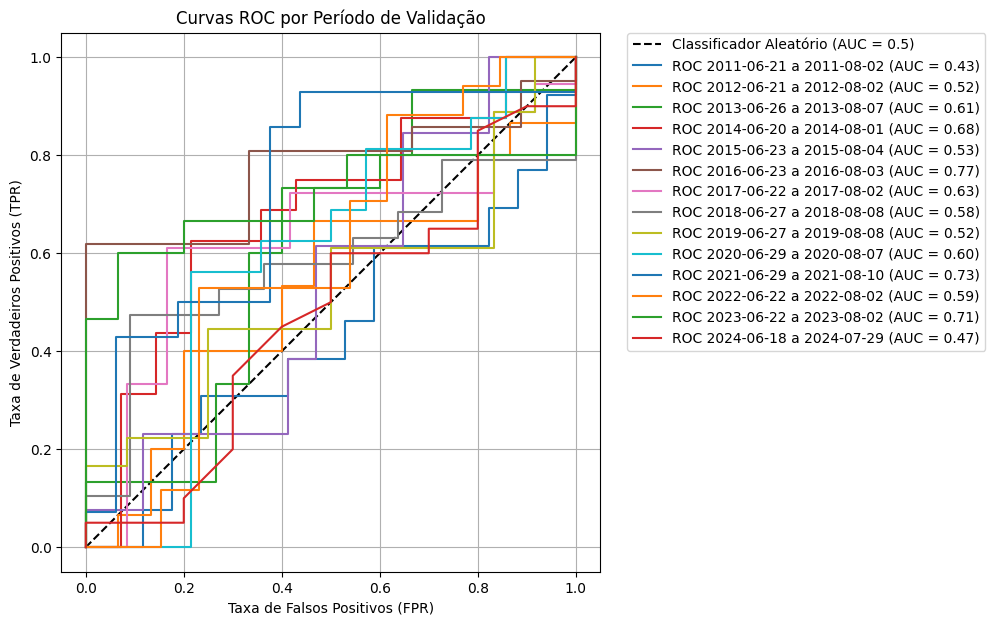

In [36]:
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# -----------------------------
# 1) Features e alvo
# -----------------------------
X = dados.drop(columns=['close','target', 'high', 'low'])
y = dados['target']

# Colunas categóricas (inclui a 'periodo' que você criou)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# -----------------------------
# 2) Parâmetros da janela
# -----------------------------
anos_por_janela = 5
dias_validacao = 30
dias_salto = 365
dias_por_janela = anos_por_janela * 300
idx_inicio_treino = 0

print("--- INÍCIO DA VALIDAÇÃO CRUZADA WALK-FORWARD (JANELA DESLIZANTE) ---")
print("Gerando Curvas ROC para cada período de validação.\n")

# -----------------------------
# 3) Plot base
# -----------------------------
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Período de Validação')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# -----------------------------
# 4) Loop Walk-Forward
# -----------------------------
while idx_inicio_treino + dias_por_janela + dias_validacao <= len(dados):
    idx_fim_treino = idx_inicio_treino + dias_por_janela
    idx_inicio_val = idx_fim_treino
    idx_fim_val = idx_inicio_val + dias_validacao

    X_treino_walk = X.iloc[idx_inicio_treino:idx_fim_treino]
    y_treino_walk = y.iloc[idx_inicio_treino:idx_fim_treino]
    X_val_walk = X.iloc[idx_inicio_val:idx_fim_val]
    y_val_walk = y.iloc[idx_inicio_val:idx_fim_val]

    if X_treino_walk.empty or X_val_walk.empty:
        break

    # Garante que há as duas classes no treino (evita erro/auc indefinido)
    if y_treino_walk.nunique() < 2:
        print(f"⏭️  Janela {X_treino_walk.index[0].date()}–{X_treino_walk.index[-1].date()} ignorada (apenas uma classe no treino).")
        proximo_salto_data = dados.index[idx_inicio_treino] + timedelta(days=dias_salto)
        idx_inicio_treino = np.argmax(dados.index >= proximo_salto_data)
        continue

    # Calcula o scale_pos_weight com base SOMENTE no treino
    n_pos = (y_treino_walk == 1).sum()
    n_neg = (y_treino_walk == 0).sum()
    spw = float(n_neg) / float(n_pos) if n_pos > 0 else 1.0

    # Pools com categorias nativas
    train_pool = Pool(data=X_treino_walk, label=y_treino_walk, cat_features=cat_features)
    val_pool = Pool(data=X_val_walk, label=y_val_walk, cat_features=cat_features)

    # Modelo CatBoost
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='F1',
        iterations=800,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        logging_level='Silent',
        scale_pos_weight=spw,
        thread_count=-1
    )

    # Treina (com early stopping opcional usando o conjunto de validação)
    model.fit(train_pool, eval_set=val_pool, verbose=False, use_best_model=True)

    # Predições (probabilidades para ROC)
    y_val_proba_walk = model.predict_proba(val_pool)[:, 1]

    # Curva ROC e AUC
    fpr, tpr, _ = roc_curve(y_val_walk, y_val_proba_walk)
    roc_auc = roc_auc_score(y_val_walk, y_val_proba_walk)

    # Plot da curva ROC da janela
    periodo_label = f'{X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}'
    plt.plot(fpr, tpr, label=f'ROC {periodo_label} (AUC = {roc_auc:.2f})')

    # Métricas de classe (usa rótulos 0/1)
    y_val_pred = model.predict(val_pool)
    print(f"✅ Validação para o período: {X_val_walk.index[0].date()} a {X_val_walk.index[-1].date()}")
    print(f"Período de Treino: {X_treino_walk.index[0].date()} a {X_treino_walk.index[-1].date()}")
    print(classification_report(y_val_walk, y_val_pred))
    print("-" * 50)

    # Move a janela
    proximo_salto_data = dados.index[idx_inicio_treino] + timedelta(days=dias_salto)
    idx_inicio_treino = np.argmax(dados.index >= proximo_salto_data)

# Finaliza o plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

**VERIFICANDO A CORRELAÇÃO DAS FEATURES**

In [37]:
# Remova a coluna 'periodo_recente' do DataFrame de features
X_treino_walk_sem_periodo = X_treino_walk.drop(columns=['periodo'])

# Concatene com a variável alvo para calcular a correlação
correlacao = pd.concat([X_treino_walk_sem_periodo, y_treino_walk], axis=1).corr()

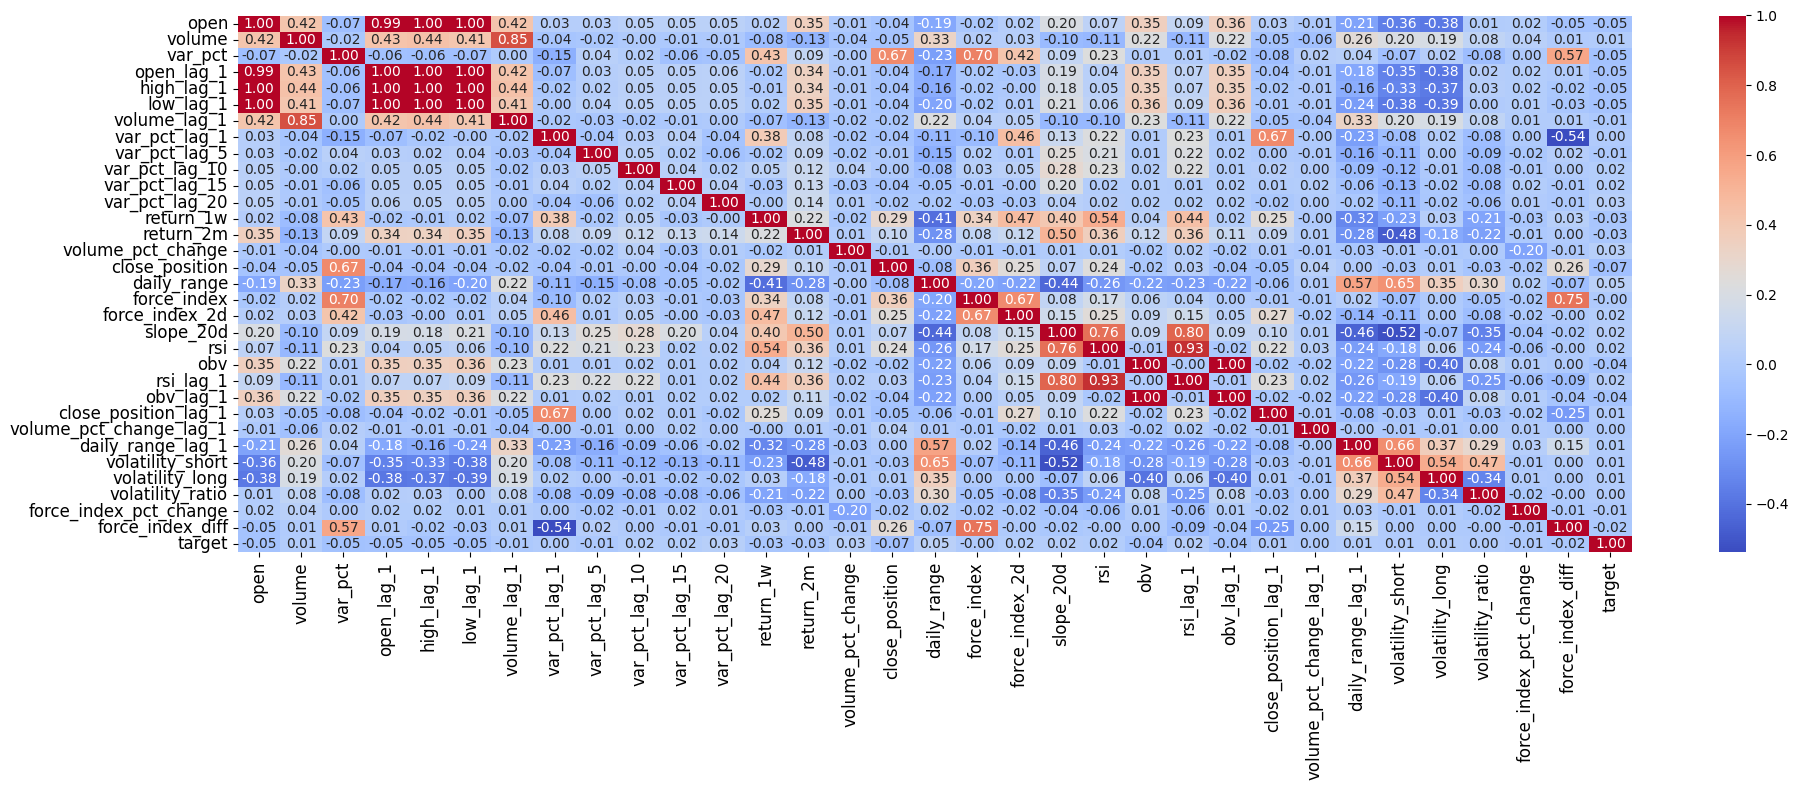

In [38]:
plt.figure(figsize=(20, 8))

sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f',  annot_kws={"size": 10})  # Aumenta o tamanho da fonte dos números dentro do heatmap

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()



In [39]:
#UM LOOP PARA VERIFICAR A IMPORTANCAI DAS FEATURES PARA A MELHORA OU PIORA DO MODELO

df = correlacao

def selecionar_features_corr(df, limite=0.90):
    """
    Remove features altamente correlacionadas (>|limite|).
    Retorna lista de colunas recomendadas para exclusão.
    """
    # calcula matriz de correlação
    corr_matrix = df.corr().abs()

    # pega a parte superior da matriz (sem duplicar)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # encontra colunas com correlação acima do limite
    to_drop = [column for column in upper.columns if any(upper[column] > limite)]

    return to_drop


colunas_excluir = selecionar_features_corr(df, limite=0.90)

print("Features altamente correlacionadas (sugestão de exclusão):")
print(list(colunas_excluir))

Features altamente correlacionadas (sugestão de exclusão):
['open_lag_1', 'high_lag_1', 'low_lag_1', 'volume_lag_1', 'force_index', 'rsi', 'rsi_lag_1', 'obv_lag_1', 'close_position_lag_1', 'daily_range_lag_1', 'volatility_short']


como o desempenho piorou, vamos manter as features.

APÓS VÁRIOS TREINAMENTOS, INCLUINDO, RETIRANDO E REINCLUIDO FEATURES, A OPÇÃO É
MANTER AS ATUAIS POR MELHOR DESEMPENHO DO MODELO

**TESTE FINAL**

In [40]:
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier, Pool

# ==============================
# Teste Final (Últimos 30 dias)
# ==============================
print("--- INÍCIO DO TESTE FINAL ---")
test_size = 30

X_treino_final = X.iloc[:-test_size].copy()
y_treino_final = y.iloc[:-test_size].copy()
X_test_final = X.iloc[-test_size:].copy()
y_test_final = y.iloc[-test_size:].copy()

# ------------------------------
# Limpeza de NaN e Inf
# ------------------------------
X_treino_final.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# Colunas categóricas
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Balanceamento: calcula scale_pos_weight com base no treino
n_pos = (y_treino_final == 1).sum()
n_neg = (y_treino_final == 0).sum()
spw = float(n_neg) / float(n_pos) if n_pos > 0 else 1.0

# Pools do CatBoost
train_pool = Pool(data=X_treino_final, label=y_treino_final, cat_features=cat_features)
test_pool = Pool(data=X_test_final, label=y_test_final, cat_features=cat_features)

# Modelo CatBoost
model_final = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    iterations=800,
    depth=7,
    learning_rate=0.05,
    random_seed=42,
    logging_level='Silent',
    scale_pos_weight=spw,
    thread_count=-1
)

# Treino
model_final.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=False)

# Predição final
y_test_pred_final = model_final.predict(test_pool)

# ------------------------------
# Relatório
# ------------------------------
print("✅ RELATÓRIO DO TESTE FINAL")
print(f"Período de Treino: {X_treino_final.index[0].date()} a {X_treino_final.index[-1].date()}")
print(f"Período de Teste: {X_test_final.index[0].date()} a {X_test_final.index[-1].date()}")
print("Acurácia:", accuracy_score(y_test_final, y_test_pred_final))
print(classification_report(y_test_final, y_test_pred_final))

--- INÍCIO DO TESTE FINAL ---
✅ RELATÓRIO DO TESTE FINAL
Período de Treino: 2005-05-30 a 2025-01-24
Período de Teste: 2025-01-27 a 2025-03-11
Acurácia: 0.7333333333333333
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        16
           1       0.64      1.00      0.78        14

    accuracy                           0.73        30
   macro avg       0.82      0.75      0.72        30
weighted avg       0.83      0.73      0.72        30



**APLICANDO TRESHOLD PARA BALANCEAR AS CLASSES NO TESTE FINAL**

In [41]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool
import numpy as np

# ==============================
# Teste Final (Últimos 30 dias) com Threshold da Validação
# ==============================
print("--- INÍCIO DO TESTE FINAL ---")
test_size = 30

X_treino_final = X.iloc[:-test_size].copy()
y_treino_final = y.iloc[:-test_size].copy()
X_test_final = X.iloc[-test_size:].copy()
y_test_final = y.iloc[-test_size:].copy()

# ------------------------------
# Limpeza de NaN e Inf
# ------------------------------
X_treino_final.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# Colunas categóricas
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Balanceamento: calcula scale_pos_weight com base no treino
n_pos = (y_treino_final == 1).sum()
n_neg = (y_treino_final == 0).sum()
spw = float(n_neg) / float(n_pos) if n_pos > 0 else 1.0

# Pools do CatBoost
train_pool = Pool(data=X_treino_final, label=y_treino_final, cat_features=cat_features)
test_pool = Pool(data=X_test_final, label=y_test_final, cat_features=cat_features)

# Modelo CatBoost
model_final = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    iterations=800,
    depth=7,
    learning_rate=0.05,
    random_seed=42,
    logging_level='Silent',
    scale_pos_weight=spw,
    thread_count=-1
)

# Treino
model_final.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=False)

# ------------------------------
# Predição com Threshold Ajustado
# ------------------------------
# Probabilidades da classe positiva
y_test_proba = model_final.predict_proba(test_pool)[:, 1]

# Threshold definido na validação walk-forward
threshold = 0.55

# Aplica o threshold para obter os rótulos finais
y_test_pred_final = (y_test_proba >= threshold).astype(int)

# ------------------------------
# Relatório
# ------------------------------
print("✅ RELATÓRIO DO TESTE FINAL (Threshold Ajustado)")
print(f"Período de Treino: {X_treino_final.index[0].date()} a {X_treino_final.index[-1].date()}")
print(f"Período de Teste: {X_test_final.index[0].date()} a {X_test_final.index[-1].date()}")
print("Acurácia:", accuracy_score(y_test_final, y_test_pred_final))
print(classification_report(y_test_final, y_test_pred_final))

--- INÍCIO DO TESTE FINAL ---
✅ RELATÓRIO DO TESTE FINAL (Threshold Ajustado)
Período de Treino: 2005-05-30 a 2025-01-24
Período de Teste: 2025-01-27 a 2025-03-11
Acurácia: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.91      0.71      0.80        14

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



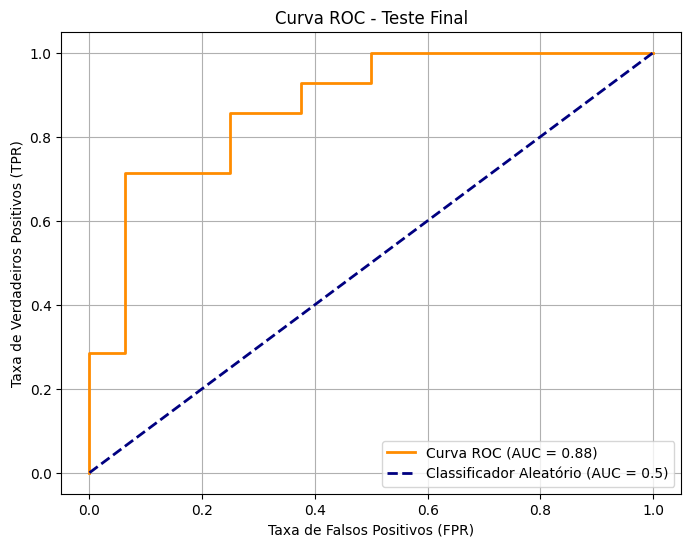

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilidades da classe positiva (1)
y_test_proba = model_final.predict_proba(test_pool)[:, 1]

# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test_final, y_test_proba)
roc_auc = roc_auc_score(y_test_final, y_test_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Classificador Aleatório (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Teste Final')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

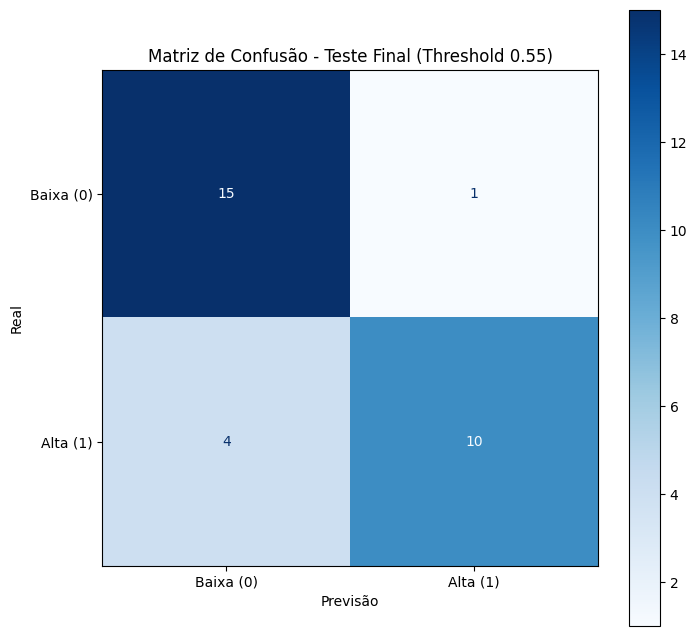

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold definido
threshold = 0.55
y_test_pred_final = (y_test_proba >= threshold).astype(int)

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_test_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Baixa (0)', 'Alta (1)'])

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusão - Teste Final (Threshold 0.55)')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

In [44]:
import joblib
import pandas as pd

# 1. Identificar as Variáveis na Memória

# O modelo final treinado:
# (Variável 'model_final' criada na Célula 41)
modelo_treinado = model_final

# O scaler ajustado:
# (Variável 'scaler' criada na Célula 12)
scaler_obj = scaler

# O DataFrame X (features) usado para treinar o modelo final:
# (Criado antes da célula 20 ou 38, garantindo 40 colunas)
# Usaremos o 'X_treino_final' que tem todas as features prontas para o treinamento
# (Assumindo que X_treino_final contém as 40 colunas de features)
colunas_treinamento = list(X_treino_final.columns)


# 2. Salvamento dos Objetos em Joblib

# Salvar o modelo CatBoost
joblib.dump(modelo_treinado, 'modelo_final_catboost.joblib')

# Salvar o scaler (Crucial para a normalização de 'volume' e 'var_pct')
joblib.dump(scaler_obj, 'scaler_dados_ibovespa.joblib')

# Salvar a lista de colunas (Crucial para garantir a ordem correta no Streamlit)
joblib.dump(colunas_treinamento, 'colunas_treinamento.joblib')


print("✅ Todos os artefatos necessários (Modelo, Scaler e Colunas) foram salvos com sucesso!")

✅ Todos os artefatos necessários (Modelo, Scaler e Colunas) foram salvos com sucesso!
